In [155]:
from PIL import Image
import shutil
import pandas as pd
import numpy as np
import os
import random
import time
import copy
import cv2
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree



from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [156]:
# 데이터 받아오기
data = pd.read_excel('../MoldingSand2/Data/Preprocessing/1and2_remove.xlsx',engine='openpyxl',sheet_name='Sheet3')

# 데이터 추출
df = data[['GFD-6', 'GFD-12', 'GFD-20', 'GFD-30', 'GFD-40', 'GFD-50', 'GFD-70',
           'GFD-100', 'GFD-140', 'GFD-200', 'GFD-270', 'Pan', 'Moisture (% by wt)',
           'Percent M.B. Active Clay', 'AFS Clay Content (% <20 µm)', 'AFS Grain Fineness No.',
           'Compactability (%)', 'Green Comp. Strength (N/sq cm)', 'Permeability No.']]

# column 이름 바꾸기
df.columns = [['GFD-6', 'GFD-12', 'GFD-20', 'GFD-30', 'GFD-40', 'GFD-50', 'GFD-70',
                 'GFD-100', 'GFD-140', 'GFD-200', 'GFD-270', 'Pan', 'Moisture',
                'Active Clay', 'ASF Clay Content', 'AFS Grain Fineness No.',
                'Compactability', 'Green Comp. Strength', 'Permeability No.']]

df.head()

,GFD-6,GFD-12,GFD-20,GFD-30,GFD-40,GFD-50,GFD-70,GFD-100,GFD-140,GFD-200,GFD-270,Pan,Moisture,Active Clay,ASF Clay Content,AFS Grain Fineness No.,Compactability,Green Comp. Strength,Permeability No.
0,0,0.0,0.0,0.16,1.36,5.94,18.55,16.95,2.39,0.27,0.08,0.0,2.59,7.52,8.60,58.827133,24.5,17.7,130.0
1,0,0.0,0.0,0.17,1.38,5.69,18.82,17.14,2.03,0.23,0.00,0.0,2.55,7.80,9.08,58.257809,24.5,17.7,124.0
2,0,0.0,0.0,0.28,2.51,7.16,13.81,17.64,3.75,0.32,0.00,0.0,2.60,7.52,9.06,59.652518,24.5,18.0,120.0
3,0,0.0,0.0,0.18,1.58,5.97,17.98,16.95,1.95,0.37,0.06,0.0,2.83,8.36,9.92,58.483570,24.5,19.8,132.0
4,0,0.0,0.0,0.20,1.54,6.24,18.48,16.76,1.88,0.26,0.00,0.0,3.00,8.64,9.28,57.791005,25.5,18.9,129.0


In [179]:
# data_0 = np.squeeze(df[['GFD-6']].to_numpy()) # 모두 0이라서 넣어줄 필요 없을듯
data_1 = np.squeeze(df[['GFD-12']].to_numpy())
data_2 = np.squeeze(df[['GFD-20']].to_numpy())
data_3 = np.squeeze(df[['GFD-30']].to_numpy())
data_4 = np.squeeze(df[['GFD-40']].to_numpy())
data_5 = np.squeeze(df[['GFD-50']].to_numpy())
data_6 = np.squeeze(df[['GFD-70']].to_numpy())
data_7 = np.squeeze(df[['GFD-100']].to_numpy())
data_8 = np.squeeze(df[['GFD-140']].to_numpy())
data_9 = np.squeeze(df[['GFD-200']].to_numpy())
data_10 = np.squeeze(df[['GFD-270']].to_numpy())
data_11 = np.squeeze(df[['Pan']].to_numpy())
data_12 = np.squeeze(df[['Moisture']].to_numpy()) # 12 - 13 같이 들어가니까 Loss가 더 낮아짐
data_13 = np.squeeze(df[['Active Clay']].to_numpy()) # Loss를 낮추는데 역할을 한다!
data_14 = np.squeeze(df[['ASF Clay Content']].to_numpy())
data_15 = np.squeeze(df[['AFS Grain Fineness No.']].to_numpy())
data_16 = np.squeeze(df[['Compactability']].to_numpy())
data_17 = np.squeeze(df[['Green Comp. Strength']].to_numpy())
data_18 = np.squeeze(df[['Permeability No.']].to_numpy())
######################################################################################

all_data_x = np.zeros((len(data_3),15))
all_data_y = np.zeros((len(data_13),))

all_data_x[:,0] = data_1
all_data_x[:,1] = data_2
all_data_x[:,2] = data_3
all_data_x[:,3] = data_4
all_data_x[:,4] = data_5
all_data_x[:,5] = data_6
all_data_x[:,6] = data_7
all_data_x[:,7] = data_8
all_data_x[:,8] = data_9
all_data_x[:,9] = data_10
all_data_x[:,10] = data_11
all_data_x[:,11] = data_12
all_data_x[:,12] = data_13
all_data_x[:,13] = data_14
all_data_x[:,14] = data_15

#16

# all_data_x[:,0] = data_5
# all_data_x[:,1] = data_6
# all_data_x[:,2] = data_7
# all_data_x[:,3] = data_8
# all_data_x[:,4] = data_9
# all_data_x[:,5] = data_10
# all_data_x[:,6] = data_11
# all_data_x[:,7] = data_12
# all_data_x[:,8] = data_13
# all_data_x[:,9] = data_14
# all_data_x[:,10] = data_15


#17
# all_data_x[:,0] = data_5
# all_data_x[:,1] = data_7
# all_data_x[:,2] = data_8
# all_data_x[:,3] = data_9
# all_data_x[:,4] = data_10
# all_data_x[:,5] = data_11
# all_data_x[:,6] = data_12
# all_data_x[:,7] = data_13
# all_data_x[:,8] = data_14
# all_data_x[:,9] = data_15

#18
# all_data_x[:,0] = data_3
# all_data_x[:,1] = data_5
# all_data_x[:,2] = data_6
# all_data_x[:,3] = data_7
# all_data_x[:,4] = data_8
# all_data_x[:,5] = data_9
# all_data_x[:,6] = data_10
# all_data_x[:,7] = data_11
# all_data_x[:,8] = data_12
# all_data_x[:,9] = data_13
# all_data_x[:,10] = data_14
# all_data_x[:,11] = data_15


# all_data_x[:,0] = data_1
# all_data_x[:,1] = data_2
# all_data_x[:,2] = data_3
# all_data_x[:,3] = data_4
# all_data_x[:,4] = data_5
# all_data_x[:,5] = data_6
# all_data_x[:,6] = data_8
# all_data_x[:,7] = data_9
# all_data_x[:,8] = data_10
# all_data_x[:,9] = data_11
# all_data_x[:,10] = data_12
# all_data_x[:,11] = data_13
# all_data_x[:,12] = data_14
# all_data_x[:,13] = data_15


all_data_y = data_18 # 16, 17 ,18

np.random.seed(5)

index = np.arange(0, all_data_x.shape[0])
np.random.shuffle(index)
all_data_x = all_data_x[index]
all_data_y = all_data_y[index]



# index = np.arange(0,all_data_y.shape[0])
# np.random.shuffle(index)
# # index = np.array([249, 282, 81, 182, 54, 314, 272, 5, 93, 287, 284, 126, 319, 59, 153, 248, 144, 136, 301, 315, 37, 317, 279, 193, 297, 289, 108, 285, 138, 161, 152, 172, 15, 168, 167, 156, 128, 34, 178, 298, 243, 333, 217, 290, 220, 51, 4, 318, 206, 70, 84, 120, 61, 169, 117, 187, 292, 26, 316, 157, 47, 185, 31, 23, 17, 39, 133, 76, 24, 281, 27, 236, 181, 22, 239, 310, 229, 44, 109, 73, 0, 18, 75, 271, 104, 52, 324, 55, 3, 203, 62, 189, 293, 332, 129, 33, 90, 111, 260, 174, 159, 89, 237, 264, 295, 224, 145, 215, 8, 124, 137, 322, 186, 96, 210, 234, 142, 118, 92, 25, 269, 115, 43, 71, 36, 80, 40, 280, 188, 274, 20, 238, 16, 207, 12, 170, 257, 261, 135, 303, 266, 155, 212, 85, 305, 173, 91, 164, 242, 321, 141, 77, 67, 13, 198, 202, 105, 256, 197, 291, 258, 176, 58, 125, 28, 101, 143, 225, 65, 196, 326, 6, 323, 213, 209, 10, 309, 110, 267, 286, 208, 312, 283, 112, 177, 56, 275, 246, 227, 252, 211, 329, 304, 165, 30, 191, 311, 204, 150, 139, 35, 240, 183, 123, 106, 331, 48, 38, 113, 232, 83, 49, 180, 78, 300, 268, 325, 87, 50, 41, 98, 306, 273, 60, 205, 162, 130, 219, 194, 259, 160, 241, 100, 184, 199, 64, 233, 122, 132, 86, 276, 200, 320, 254, 72, 278, 270, 251, 223, 244, 11, 95, 302, 102, 158, 107, 21, 151, 201, 330, 46, 195, 121, 45, 82, 231, 255, 57, 97, 2, 116, 214, 299, 32, 69, 245, 99, 222, 307, 131, 288, 226, 134, 313, 68, 127, 179, 14, 149, 218, 1, 228, 166, 147, 103, 66, 250, 235, 146, 190, 328, 79, 221, 327, 247, 263, 42, 9, 163, 253, 154, 114, 53, 171, 29, 88, 148, 262, 7, 140, 63, 294, 296, 175, 308, 277, 216, 74, 265, 19, 230, 94, 119, 192]) 
# all_data_x = all_data_x[index]
# all_data_y = all_data_y[index]

######################################################################################
print(all_data_x.shape)
print(all_data_y.shape)

(334, 15)
(334,)


In [180]:
# col_names = ['GFD-6', 'GFD-12', 'GFD-20', 'GFD-30', 'GFD-40', 'GFD-50', 'GFD-70',
#                  'GFD-100', 'GFD-140', 'GFD-200', 'GFD-270', 'Pan', 'Moisture',
#                 'Active Clay', 'Clay Content', 'Grain Fineness No.']
# all_data_x = pd.DataFrame(all_data_x, columns = col_names) # X를 행렬로 표현, 칼럼 이름 설정
# all_data_x
x_train, x_test, y_train, y_test = train_test_split(all_data_x, all_data_y, shuffle = False, test_size = 0.2) # test_size = 0.25
###############################################################################################################
# input_1 = pd.read_csv('../MoldingSand/Data/Preprocessing/data_generation_second/new_data_for_input_1.csv')
# input_2 = pd.read_csv('../MoldingSand/Data/Preprocessing/data_generation_second/new_data_for_input_2.csv')
# input_3 = pd.read_csv('../MoldingSand/Data/Preprocessing/data_generation_second/new_data_for_input_3.csv')
# output = pd.read_csv('../MoldingSand/Data/Preprocessing/data_generation_second/new_data_for_output.csv')

# np.random.seed(16)
# index = np.arange(0, len(input_3))
# np.random.shuffle(index)

# input_1 = input_1.to_numpy()
# input_2 = input_2.to_numpy()
# input_3 = input_3.to_numpy()
# output = output.to_numpy()

# input_1 = input_1[index]
# input_2 = input_2[index]
# input_3 = input_3[index]
# output = output[index]

# x_train = np.concatenate((x_train,input_1[:25,:3]),axis =0)
# x_train = np.concatenate((x_train,input_2[25:50,:3]),axis =0)
# x_train = np.concatenate((x_train,input_3[50:75,:3]),axis =0)
# x_train = np.concatenate((x_train,output[75:100,:3]),axis =0)

# y_train = np.concatenate((y_train,input_1[:25,-1]),axis =0)
# y_train = np.concatenate((y_train,input_2[25:50,-1]),axis =0)
# y_train = np.concatenate((y_train,input_3[50:75,-1]),axis =0)
# y_train = np.concatenate((y_train,output[75:100,-1]),axis =0)
###############################################################################################################
print(x_train.shape) 
print(type(x_train)) 
print(y_train.shape) 
print(type(y_train)) 

(267, 15)
<class 'numpy.ndarray'>
(267,)
<class 'numpy.ndarray'>


In [181]:
mean_x = np.mean(x_train, axis = 0)   
std_x = np.std(x_train, axis = 0)   

mean_y = np.mean(y_train, axis = 0)   
std_y = np.std(y_train, axis = 0)   

In [182]:
x_train = (x_train - mean_x) / std_x
# y_train = (y_train - mean_y) / std_y

x_test = (x_test - mean_x) / std_x

In [183]:
from lightgbm import LGBMRegressor

In [172]:
model = LGBMRegressor(n_estimators=200, learning_rate = 0.05, subsample = 0.6)
model_param_grid = {'n_estimators' : [200, 250, 300, 350, 400, 450],
                    'learning_rate' : [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
                    'max_depth' : [3, 4, 5, 6, 7 ,8],
                    'subsample': [0.6, 0.8, 1.0]
                   }

model_grid = GridSearchCV(model,
                          param_grid = model_param_grid,
                          scoring = 'neg_mean_absolute_error', #make_score(mean_absolute_error, squared=False),
                          n_jobs = -1,
                          verbose = 2,
                          cv = 4,
                          refit = True
                         )
model_grid.fit(x_train, y_train)#, **{'eval_metric': 'mae'})

Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 2553 out of 2592 | elapsed:    8.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:    8.3s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=4,
             estimator=LGBMRegressor(learning_rate=0.05, n_estimators=200,
                                     subsample=0.6),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [200, 250, 300, 350, 400, 450],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=2)

In [174]:
model_grid_df = pd.DataFrame(model_grid.cv_results_)
model_grid_df.loc[:, ['mean_test_score', "params"]]

,mean_test_score,params
0,-8.970901,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
1,-8.970901,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
2,-8.970901,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
3,-8.741096,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
4,-8.741096,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es..."
...,...,...
643,-5.617140,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti..."
644,-5.617140,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti..."
645,-5.619275,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti..."
646,-5.619275,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti..."


In [175]:
for i in range(648):
    if model_grid_df.loc[:, ['rank_test_score', "params"]]['rank_test_score'][i] == 1:
        print(model_grid_df.loc[:, ['rank_test_score', "params"]]['params'][i])

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 450, 'subsample': 0.6}
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 450, 'subsample': 0.8}
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 450, 'subsample': 1.0}


In [184]:
# model_test = LGBMRegressor(learning_rate = 0.01,
#                           max_depth = 5,
#                           n_estimators = 300,
#                           subsample = 0.6
#                          )
# 17
# model_test = LGBMRegressor(learning_rate = 0.05,
#                           max_depth = 6,
#                           n_estimators = 250,
#                           subsample = 0.6
#                          )
# 18
model_test = LGBMRegressor(learning_rate = 0.01,
                          max_depth = 6,
                          n_estimators = 450,
                          subsample = 0.6
                         )

model_test.fit(x_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=6, n_estimators=450, subsample=0.6)

In [185]:
y_pred = model_test.predict(x_test)
y_true = y_test

# y_pred = (y_pred * std_y) + mean_y 

mae = mean_absolute_error(y_true, y_pred) 
# mse = mean_squared_error(y_true, y_pred) 
# print('mse: ', mse)
print('mae: ', mae) 

mae:  4.666819229818046


In [186]:
###########################18########################
model_test = XGBRegressor(learning_rate = 0.1,
                          max_depth = 7,
                          n_estimators = 200,
                          subsample = 0.6
                         )

model_test.fit(x_train, y_train)

[17:53:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=7, n_estimators=200, subsample=0.6)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

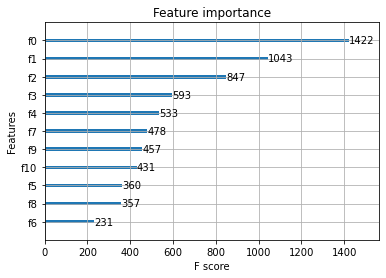

In [15]:
plot_importance(model_test)
# plot_importance(model)

In [16]:
y_pred = model_test.predict(x_test)
y_true = y_test

# y_pred = (y_pred * std_y) + mean_y 

mae = mean_absolute_error(y_true, y_pred) 
# mse = mean_squared_error(y_true, y_pred) 
# print('mse: ', mse)
print('mae: ', mae) 

mae:  4.645225069416103


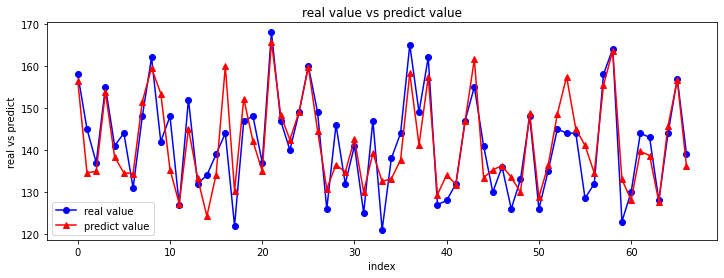

In [17]:
fig = plt.figure( figsize = (12, 4) )
chart = fig.add_subplot(1,1,1)
chart.plot(y_true, marker='o', color='blue', label='real value')
chart.plot(y_pred, marker='^', color='red', label='predict value')
chart.set_title('real value vs predict value')
plt.xlabel('index')
plt.ylabel('real vs predict')
plt.legend(loc = 'best')